<b>CIFAR-10 Keras implementation</b>
<br>
This is my implementation for the CIFAR-10 contest conducted by kaggle
The training data is inside the folder './train/train/'
while testing data is inside './test/'

This implementation achieved an accuracy of 82%

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from PIL import Image
from os import path
np.random.seed(2)
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import cv2
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, Activation, add
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [2]:
# Read training labels
label = pd.read_csv("./train/trainLabels.csv")


In [3]:
# get the unique label names
a = np.unique(label['label'])
a.sort
# convert label names to numericals
Y_train = label['label'].apply(a.tolist().index)

9    5000
8    5000
7    5000
6    5000
5    5000
4    5000
3    5000
2    5000
1    5000
0    5000
Name: label, dtype: int64

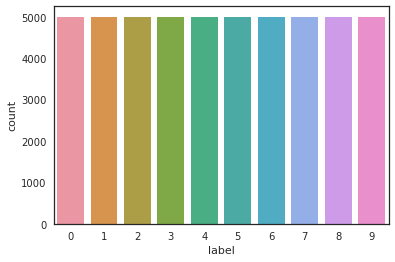

In [4]:
# check frequency of occurence of each label
g = sns.countplot(Y_train)
Y_train.value_counts()

In [5]:
# One-hot encoding
Y_train = to_categorical(Y_train, num_classes = 10)

In [6]:
# Function to read images and convert to numpy array. 
def read_all_images(DIR = './',batch_size=0,st=0):
    l = listdir(DIR)
    l = [s.replace('.png', '') for s in l]
    l = map(int,l)
    l.sort()
    if batch_size == 0:
        batch_size = len(l)
    
    ims = np.zeros((batch_size,32,32,3),dtype=np.uint8)
    print "Starting from {}".format(st)
    for i in range(batch_size):
        img = cv2.imread(DIR+str(l[i+st]) + '.png')
        img.reshape(32,32,3)
        ims[i,:,:,:] = img
    return ims

In [7]:
#Create the numpy array for training
if path.isfile('./train.npy'):
    X_train = np.load('./train.npy')
else:
    X_train = read_all_images('./train/train/')
    np.save('./train.npy',X_train)


In [9]:
# Normalize the data set
X_train = X_train / 255.


In [ ]:
# Sanity check
# check = X_train[9]
# cv2.imshow('img',check)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [ ]:
# Y_train[9]

In [10]:
# Set the random seed
random_seed = 2

In [ ]:
# Split the train and the validation set for the fitting 20% val
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)

In [ ]:
#Sanity check
# check = X_train[10]
# cv2.imshow('img',check)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
#Y_train[10]

In [ ]:
# data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
# Keras functional API preload is used to continue training when interrupted
def my_model(preload = None):
    
    inputs = Input(shape=(32,32,3))
    
    conv1 = Conv2D(32,(3,3),padding='same')(inputs)
    conv1 = BatchNormalization(axis=-1)(conv1)
    conv1 = Activation('relu')(conv1)
    
    conv1 = Conv2D(32,(3,3),padding='same')(conv1)
    conv1 = BatchNormalization(axis=-1)(conv1)
    conv1 = Activation('relu')(conv1)
    
    pool1 = MaxPool2D((2,2),padding='same')(conv1)
    pool1 = Dropout(0.2)(pool1)
    
    conv2 = Conv2D(64,(3,3),padding='same')(pool1)
    conv2 = BatchNormalization(axis=-1)(conv2)
    conv2 = Activation('relu')(conv2)
    
    conv2 = Conv2D(64,(3,3),padding='same')(conv2)
    conv2 = BatchNormalization(axis=-1)(conv2)
    conv2 = Activation('relu')(conv2)
    
    pool2 = MaxPool2D((2,2),padding='same')(conv2)
    pool2 = Dropout(0.2)(pool2)

    flat = Flatten()(pool2)
    
    dense = Dense(256,activation = 'relu')(flat)
    dense = Dropout(0.2)(dense)

    dense = Dense(128,activation = 'relu')(dense)
    dense = Dropout(0.2)(dense)
    
    out = Dense(10,activation='softmax')(dense)
    
    model = Model(inputs,out)
    
    if preload:
        model.load_weights(preload)
    
    return model

In [ ]:
# Define the optimizer
optimizer = Adam(lr=1e-3)

In [ ]:
# callback to save weights with least validation loss
bestval = ModelCheckpoint('bestval.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)


In [ ]:
# create and compile model
model = my_model('bestval.h5')
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Define epochs and batch_size
epochs = 50 
batch_size = 100

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,bestval])

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
#load model with best weights
model.load_weights('bestval.h5')

In [ ]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((32,32,3)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
# For prediction read a batch of 1000 images and append results
results = np.zeros((1))
for i in range(300):
    print "Predicting batch {} of {} ".format(i+1,300)
    test = read_all_images('./train/test/',1000,i*1000)
    test = test / 255.
    prediction = model.predict(test)
    prediction = np.argmax(prediction,axis=1)
    results = np.append(results,prediction)
    

In [ ]:
#Remove extra element and convert to int
results = results[1:]
results = map(int,results)

In [ ]:
#Convert label numbers to names
results = a[results]

In [ ]:
#Create a table
results = pd.Series(results,name="label")

In [ ]:
submission = pd.concat([pd.Series(range(1,300001),name = "id"),results],axis = 1)

submission.to_csv("submit.csv",index=False)